# Deep Learning Framework -- Project #2

### Ahmed Furkan Ozkalay   /   Aras Mumcuyan

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import numpy as np

from utils import label2one_hot
from utils.generate_data import generate_data, generate_grid_data
from utils.load_data import load_data
from modules import Dropout, Linear, Sequential
from modules.losses import LossMSE, LossCrossEntropy
from optimizers import Optimizer, SGD

import torch
from torchvision import datasets

In [2]:
"""
    Utility functions for visualization,
    You can find the same implmentation in utils module (visualize.py)
"""

from typing import * 
from matplotlib import gridspec

radius=1/np.sqrt(2*np.pi)
center=np.array([0.5, 0.5])
    
def plot_data_multiple(list_of_points: List, 
                       list_of_labels: List, 
                       grid_space: Tuple[int, int],
                       filename: str = None,
                       titles=None, 
                       messages=None):

    assert len(list_of_points) == len(list_of_labels)
    plot_number = len(list_of_points)

    x_num, y_num = grid_space[0], grid_space[1]
    fig = plt.figure(figsize=(8*y_num, 8*x_num))
    gs = gridspec.GridSpec(x_num, y_num)
    
    for idx, (points, labels) in enumerate(zip(list_of_points, list_of_labels)):
        # create subplot based on grid space
        title = '' if titles is None else titles[idx]
        msg = '' if messages is None else messages[idx]
        
        ax = plt.subplot(gs[idx])
        draw_points_circle(ax, points, labels, title=title, msg=msg)
    
    if filename is not None:
        plt.savefig('{}.pdf'.format(filename), bbox_inches='tight')
        plt.savefig('{}.png'.format(filename), bbox_inches='tight')

def draw_points_circle(ax, points, labels, title, msg='', minn=0, maxx=1):
    
    circle = plt.Circle(center, radius, color='r', fill=False, linewidth=5)
    ax.add_patch(circle)
    
    if torch.is_tensor(points):
        points = points.numpy()
        ax.scatter(points[:,0], points[:,1], c=labels)
    # ax.set_xlim(minn, maxx)
    # ax.set_ylim(minn, maxx)
    
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(msg, fontsize=16)
    
    for tick_x, tick_y in zip(ax.xaxis.get_major_ticks(), ax.yaxis.get_major_ticks()):
        tick_x.label.set_fontsize(16)
        tick_y.label.set_fontsize(16)
        
def plot_data(points, labels, 
              minn=0, maxx=1, 
              radius=1/np.sqrt(2*np.pi), 
              center=np.array([0.5, 0.5]),
             title=None):
    
    fig, ax = plt.subplots(figsize=(8, 8))
    draw_points_circle(ax, points, labels, title)
    
    
def plot_report(train_report, title="", figsize=(10,6), is_save_fig=False, filename=''):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch', figsize)
    ax1.plot(train_report["train_loss"], label = "train")
    ax1.plot(train_report["val_loss"], label = "validation")
    ax2.plot(train_report["train_acc"], label = "train")
    ax2.plot(train_report["val_acc"], label = "validation")
    finalize_standardplot(fig, ax1, ax2)

    if is_save_fig:
        plt.savefig('{}.pdf'.format(filename), bbox_inches='tight')
        plt.savefig('{}.png'.format(filename), bbox_inches='tight')

    return fig

def prepare_standardplot(title, xlabel, figsize=(10,6)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_v2(train_report, title=""):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(train_report["train_loss"], label = "train")
    ax1.plot(train_report["val_loss"], label = "validation")
    ax2.plot(train_report["train_acc"], label = "train")
    ax2.plot(train_report["val_acc"], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


In [52]:
def plot_model_evaluation(opt: Optimizer,
                          model: Sequential,
                          train_dataset, # tuple of 2
                          test_dataset,  # tuple of 2
                          epoch_list, # list of epoch
                          grid_space):
    """
        This function is created for plotting the prediction of the model
        through specified epochs
        Args:
            opt: Optimizer (SGD) for training
            train_dataset = (x_train, y_train) 
            test_dataset = (x_test, y_test) 
            epoch_list = [epoch#1, epoch#2, ... ] to plot test at that 
            grid_space: (nRows, nCols)
    """
    
    x_train, y_train = train_dataset[0], train_dataset[1]
    x_test, y_test = test_dataset[0], test_dataset[1]
    
    idx = 1
    epoch_sizes = [epoch_list[0]]
    while idx < len(epoch_list):
        epoch_sizes.append(epoch_list[idx] - epoch_list[idx-1])
        idx += 1
        
    test_accs = []
    test_losses = []
    x_tests, y_preds = [], []
    
    messages = []
    titles = []
    
    for idx, epoch in enumerate(epoch_sizes):
        opt.train(model, x_train, y_train, 
                        batch_size = 128,
                        num_of_epochs=epoch, 
                        val_split=0.2,  # the ratio of split for validation
                        verbose=0)
        test_acc, test_loss, y_pred = model.evaluate(x_test, y_test, return_pred=True)
        print('Epoch: {} -- test_acc: {} --  test_loss: {}'.format(epoch_list[idx], test_acc, test_loss))
        
        msg = 'test_acc: {:.4f} --  test_loss: {:.4f}'.format(test_acc, test_loss)
        messages.append(msg)
        
        titles.append('Trained epoch: {}'.format(epoch_list[idx]))
        x_tests.append(x_test)
        y_preds.append(y_pred)
        
        
    plot_data_multiple(x_tests, y_preds, grid_space, titles=titles, messages=messages, filename='plot_series')

# 1. Data Generation

Please check generate_data.py in utils module to see the implementation of following two functions. 

   * **generate_data** (# of points) : uniform randomly selects a floating point between [0, 1]
    
   * **generate_grid_data** (# of points per dim) : no randomness involved, it divides the space into small grids and creates dataset based on this division
   
   Below, these two data generation is illustrated. 
   
   As it is stated in the project description, randomly generated dataset is used for training. On the other hand, grid generated data will be used as testing.

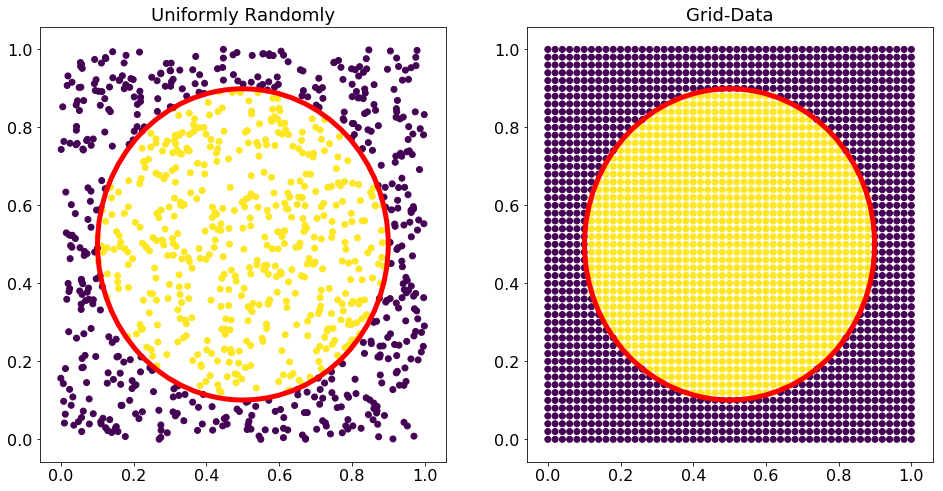

In [4]:
x_train, y_train_label = generate_data(num_of_points=1000)
x_test, y_test_label = generate_grid_data(num_of_points_per_dim=51)

plot_data_multiple([x_train, x_test], 
                   [y_train_label, y_test_label], 
                   grid_space=(1,2),
                   titles=['Uniformly Randomly', 'Grid-Data'], filename='generated_data')

# 2. Model Generation

In this section, we show an example of how to create a model in our framework.

Model is an object of Sequential containing ordered list of layers as it is assign using add function.
As you can see, it seems like Keras interface, however, compilation of the model is different.
We set loss layer to model (by assign it to loss attribute of Sequential object) and optimizer is the one which performs training procedure.

In the following subsections, we show two different model construction containing both categorical-crossentropy-loss network as well as mean-square-loss network.

In [31]:
def get_categorical_model(input_neurons, output_neurons, layers=None):
    if layers is None:
        layers = [25, 25, 25]

    default_act = 'relu'
    model = Sequential()
    
    idx = 1
    layers.insert(0, input_neurons)
    while idx < len(layers):
        model.add(Linear(out=layers[idx], input_size=layers[idx-1], activation=default_act))
        idx += 1
        
    #model.add(Dropout(prob=0.2))
    model.add(Linear(out=output_neurons, activation='softmax'))

    # Set loss function to model: Sequential object
    ce = LossCrossEntropy()
    model.loss = ce
    return model

###  2.1 A.) Test with Categorical Crossentropy

In [32]:
cat_model = get_categorical_model(input_neurons=2, output_neurons=2)
cat_model.print_model()

**************************************************************
Layer Name 		 Input Shape		 Output Shape
**************************************************************
0_Linear		 (2)			 (25)
1_ReLU
2_Linear		 (25)			 (25)
3_ReLU
4_Linear		 (25)			 (25)
5_ReLU
6_Linear		 (25)			 (2)
7_Softmax
**************************************************************
Loss Function: 		LossCrossEntropy 
**************************************************************



In [33]:
# create an optimizer 
# by specifying learning rate, momentum coefficent and L2 regularization coefficient
cat_model = get_categorical_model(input_neurons=2, output_neurons=2)

opt = SGD(lr=0.1, momentum_coef=0.5, weight_decay=0.0) 

# Since this network for generated for classification, we convert y_train_label to one-hot-encoding
# with values 0s and 1s
y_train = label2one_hot(y_train_label, val=0)

# Given model, x_train and y_train optimizer trains model
train_report = opt.train(cat_model, x_train, y_train, 
                        batch_size = 128,   # batch_size
                        num_of_epochs=1000,  # specification of # epochs for training
                        val_split=0.2,  # the ratio of split for validation
                        verbose=1) # set it 1 to report model performance

# Train report is the log of train_loss, train_acc, val_loss and val_acc 
for key, value in train_report.items():
    print('key: {0}, len({0}): {1}'.format(key, len(value)))
    

epoch: 100 ---> train_loss: 0.4813, train_acc: 0.7487 ----- val_loss: 0.4356, val_acc: 0.7850
epoch: 200 ---> train_loss: 0.0790, train_acc: 0.9675 ----- val_loss: 0.1305, val_acc: 0.9350
epoch: 300 ---> train_loss: 0.0662, train_acc: 0.9675 ----- val_loss: 0.0806, val_acc: 0.9700
epoch: 400 ---> train_loss: 0.0377, train_acc: 0.9862 ----- val_loss: 0.0711, val_acc: 0.9700
epoch: 500 ---> train_loss: 0.2402, train_acc: 0.9162 ----- val_loss: 0.4239, val_acc: 0.8650
epoch: 600 ---> train_loss: 0.0413, train_acc: 0.9812 ----- val_loss: 0.0989, val_acc: 0.9600
epoch: 700 ---> train_loss: 0.0298, train_acc: 0.9912 ----- val_loss: 0.0514, val_acc: 0.9800
epoch: 800 ---> train_loss: 0.0284, train_acc: 0.9887 ----- val_loss: 0.0434, val_acc: 0.9800
epoch: 900 ---> train_loss: 0.0259, train_acc: 0.9912 ----- val_loss: 0.0832, val_acc: 0.9650
key: train_loss, len(train_loss): 1000
key: train_acc, len(train_acc): 1000
key: val_loss, len(val_loss): 1000
key: val_acc, len(val_acc): 1000


### 2.1 B.) Evaluating & Testing Model

In [34]:
# convert y_test_label to one-hot-encoding (the same as training procedure that we have followed)
y_test = label2one_hot(y_test_label, val=0)

# call evaluate method of Sequential object to get test_accuracy, test_loss and predictions (boolean flag)
test_acc, test_loss, y_preds_cat = cat_model.evaluate(x_test, y_test, return_pred=True) 
print('TestAcc: {} | TestLoss: {} '.format(test_acc, test_loss))

# second 

TestAcc: 0.9830834269523621 | TestLoss: 0.03839671239256859 


### 2.1 C.) Visualization of Categorical Crossentropy Loss Predictions

After 1000 epoch, the model has an accuracy of 97.9% and 0.0466 loss.

Let's visualize its predictions and see which part could not be learned by the network.

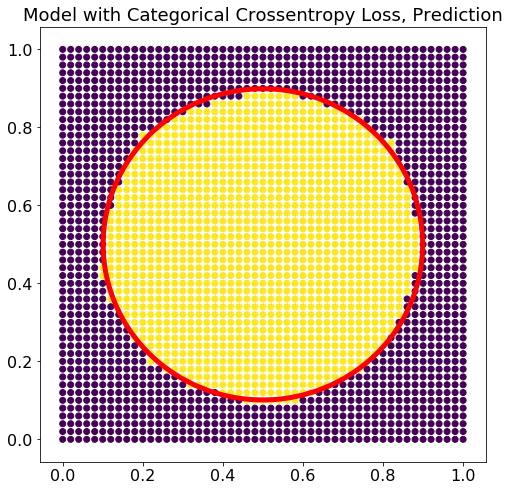

In [35]:
plot_data(x_test, y_preds_cat, title='Model with Categorical Crossentropy Loss, Prediction')

The red line is true decision boundary. As the network learns most of the datapoint, it may misclassify the points 
that are close to the boundary which is expected. We will dive into the analysis of this in subsequent sections.

### 2.1 D.) Learning Curves

In [36]:
def train(model, train_dataset, val_dataset):

    (x_train, y_train) = train_dataset

    lr = 0.2
    momentum_coef = 0
    weight_decay = 0.2

    print(model)

    opt = SGD(lr=lr, momentum_coef=momentum_coef, weight_decay=weight_decay)
    print('Optimizer: {} with (lr: {} -- momentum_coef: {} -- weight_decay: {})'.
          format(opt.__class__.__name__, lr, momentum_coef, weight_decay))

    num_of_epochs = 1000
    batch_size = 128
    val_split = 0.1
    print('Training is about the start with epoch: {}, batch_size: {}, validation_split: {}'
          .format(num_of_epochs, batch_size, val_split))

    return opt.train(model,
              x_train, y_train,
              num_of_epochs=num_of_epochs,
              batch_size=batch_size,
              val_set=val_dataset,
              verbose=1)


In [37]:
# Generate data
x_train, y_train_label = generate_data(num_of_points=2000)
y_train = label2one_hot(y_train_label, val=0)  # convert labels to 1-hot encoding

x_val, y_val_label = generate_data(num_of_points=1000)
y_val = label2one_hot(y_val_label, val=0)  # convert labels to 1-hot encoding

# create model
model = get_categorical_model(input_neurons=x_train.shape[1], output_neurons=y_train.shape[1])

# train model with manually generated train and validation set
train_report = train(model, (x_train, y_train), (x_val, y_val))

**************************************************************
Layer Name 		 Input Shape		 Output Shape
**************************************************************
0_Linear		 (2)			 (25)
1_ReLU
2_Linear		 (25)			 (25)
3_ReLU
4_Linear		 (25)			 (25)
5_ReLU
6_Linear		 (25)			 (2)
7_Softmax
**************************************************************
Loss Function: 		LossCrossEntropy 
**************************************************************

Optimizer: SGD with (lr: 0.2 -- momentum_coef: 0 -- weight_decay: 0.2)
Training is about the start with epoch: 1000, batch_size: 128, validation_split: 0.1


TypeError: train() got an unexpected keyword argument 'val_set'

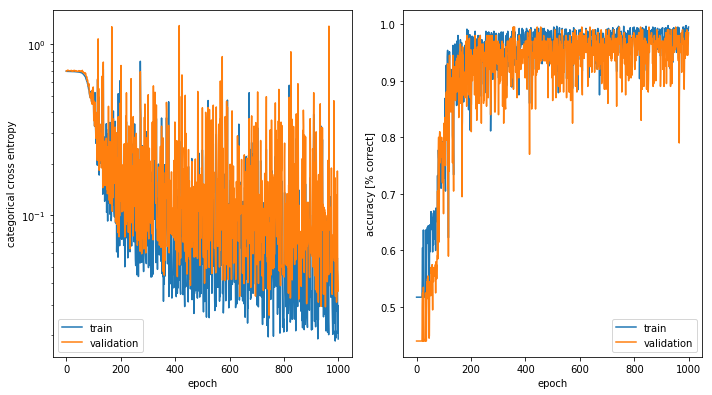

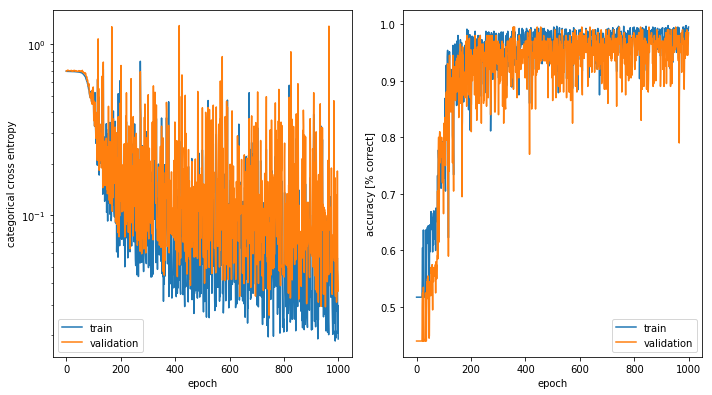

In [38]:
plot_report(train_report)

### 2.2 A.) Test with Mean Square Error

In [39]:
# Prepare data for Mean Square Error - network
x_train, y_train_label = generate_data(num_of_points=1000)
x_test, y_test_label = generate_grid_data(num_of_points_per_dim=51)

# Since this network for generated for classification, we convert y_train_label to one-hot-encoding
# with values -1s and 1s
y_train = label2one_hot(y_train_label, val=-1)
y_test = label2one_hot(y_test_label, val=-1)

In [88]:
def get_mse_model(input_neurons, output_neurons, layers=None):
    """
    creates a model with MSE loss
    :param input_neurons: input neuron number
    :param output_neurons: output neuron number
    :param layers: list of intermediate neuron sizes, default is the number of neurons and layer sizes for neuron
    :return: network with MSE loss
    """
    if layers is None:
        layers = [25, 25, 25]

    default_act = 'tanh'
    model = Sequential()

    idx = 1
    layers.insert(0, input_neurons)
    while idx < len(layers):
        model.add(Linear(out=layers[idx], input_size=layers[idx - 1], activation=default_act))
        idx += 1

    #model.add(Dropout(prob=0.2))
    model.add(Linear(out=output_neurons, activation='tanh'))

    # Set loss function to model: Sequential object
    mse = LossMSE()
    model.loss = mse
    return model

In [96]:
mse_model = get_mse_model(input_neurons=x_train.shape[1], output_neurons=y_train.shape[1])

# create an optimizer 
# by specifying learning rate, momentum coefficent and L2 regularization coefficient
# (same as categorical-cross entropy)
opt = SGD(lr=0.1, momentum_coef=0.0, weight_decay=0.0) 

y_train = label2one_hot(y_train_label, val=-1)

# Given model, x_train and y_train optimizer trains model
train_report = opt.train(mse_model, x_train, y_train, 
                        batch_size = 128,   # batch_size
                        num_of_epochs=500,  # specification of # epochs for training
                        val_split=0.2,  # the ratio of split for validation
                        verbose=1) # set it 1 to report model performance


epoch: 100 ---> train_loss: 1.9755, train_acc: 0.5088 ----- val_loss: 1.9675, val_acc: 0.5250
epoch: 200 ---> train_loss: 0.8985, train_acc: 0.8263 ----- val_loss: 0.7726, val_acc: 0.8500
epoch: 300 ---> train_loss: 0.6676, train_acc: 0.8788 ----- val_loss: 0.6963, val_acc: 0.8800
epoch: 400 ---> train_loss: 0.1021, train_acc: 0.9887 ----- val_loss: 0.1697, val_acc: 0.9750


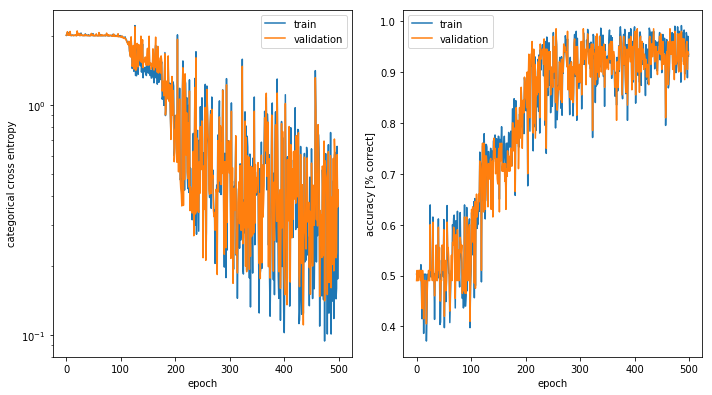

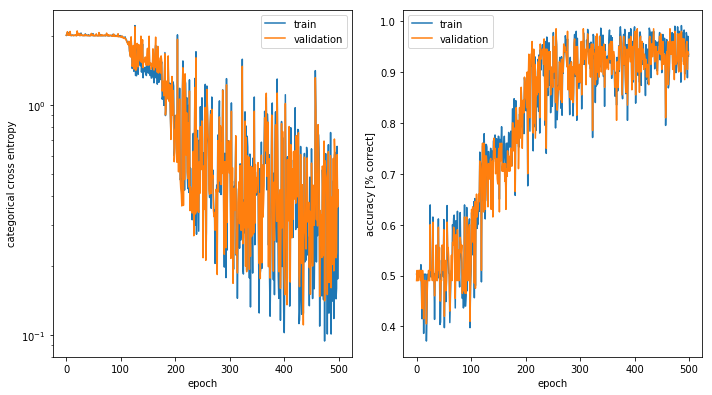

In [100]:
plot_report(train_report, is_save_fig=True)

### 2.2 B.) Evaluating & Testing Model

In [99]:
# convert y_test_label to one-hot-encoding (the same as training procedure that we have followed)
y_test = label2one_hot(y_test_label, val=-1)

# call evaluate method of Sequential object to get test_accuracy, test_loss and predictions (boolean flag)
test_acc, test_loss, y_preds_mse = mse_model.evaluate(x_test, y_test, return_pred=True) 
print('TestAcc: {} | TestLoss: {} '.format(test_acc, test_loss))

# second 

TestAcc: 0.9307958483695984 | TestLoss: 0.4300081431865692 


### 2.2 C.) Visualization of Mean Square Error Loss Predictions

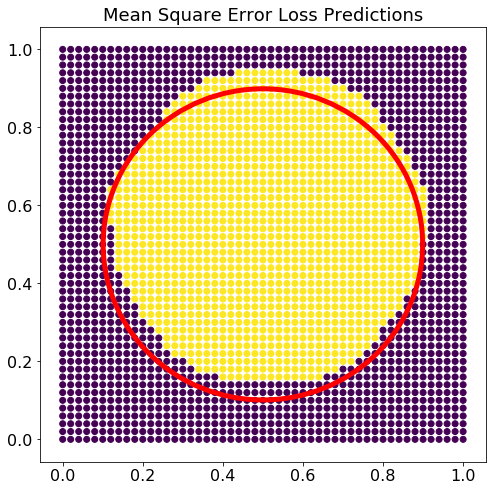

In [47]:
plot_data(x_test, y_preds_mse, title='Mean Square Error Loss Predictions')

## 3. Experiments

In this section, we will show how this learning process goes through epochs. In order to do this, during training we 
stop gradient update and make model to predict our test set. As a result, t

In [48]:
cat_model = get_categorical_model(input_neurons=2, output_neurons=2)
cat_model.print_model()

**************************************************************
Layer Name 		 Input Shape		 Output Shape
**************************************************************
0_Linear		 (2)			 (25)
1_ReLU
2_Linear		 (25)			 (25)
3_ReLU
4_Linear		 (25)			 (25)
5_ReLU
6_Linear		 (25)			 (2)
7_Softmax
**************************************************************
Loss Function: 		LossCrossEntropy 
**************************************************************



100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 173.73it/s]


Epoch: 50 -- test_acc: 0.5213379263877869 --  test_loss: 0.6910672187805176


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.96it/s]


Epoch: 100 -- test_acc: 0.6151480078697205 --  test_loss: 0.6865343451499939


100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 169.62it/s]


Epoch: 125 -- test_acc: 0.7124183177947998 --  test_loss: 0.6615942120552063


100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 165.13it/s]


Epoch: 150 -- test_acc: 0.6801230311393738 --  test_loss: 0.553494930267334


100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 167.53it/s]


Epoch: 300 -- test_acc: 0.9138792753219604 --  test_loss: 0.19236746430397034


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 154.75it/s]


Epoch: 500 -- test_acc: 0.9527105093002319 --  test_loss: 0.09912276268005371


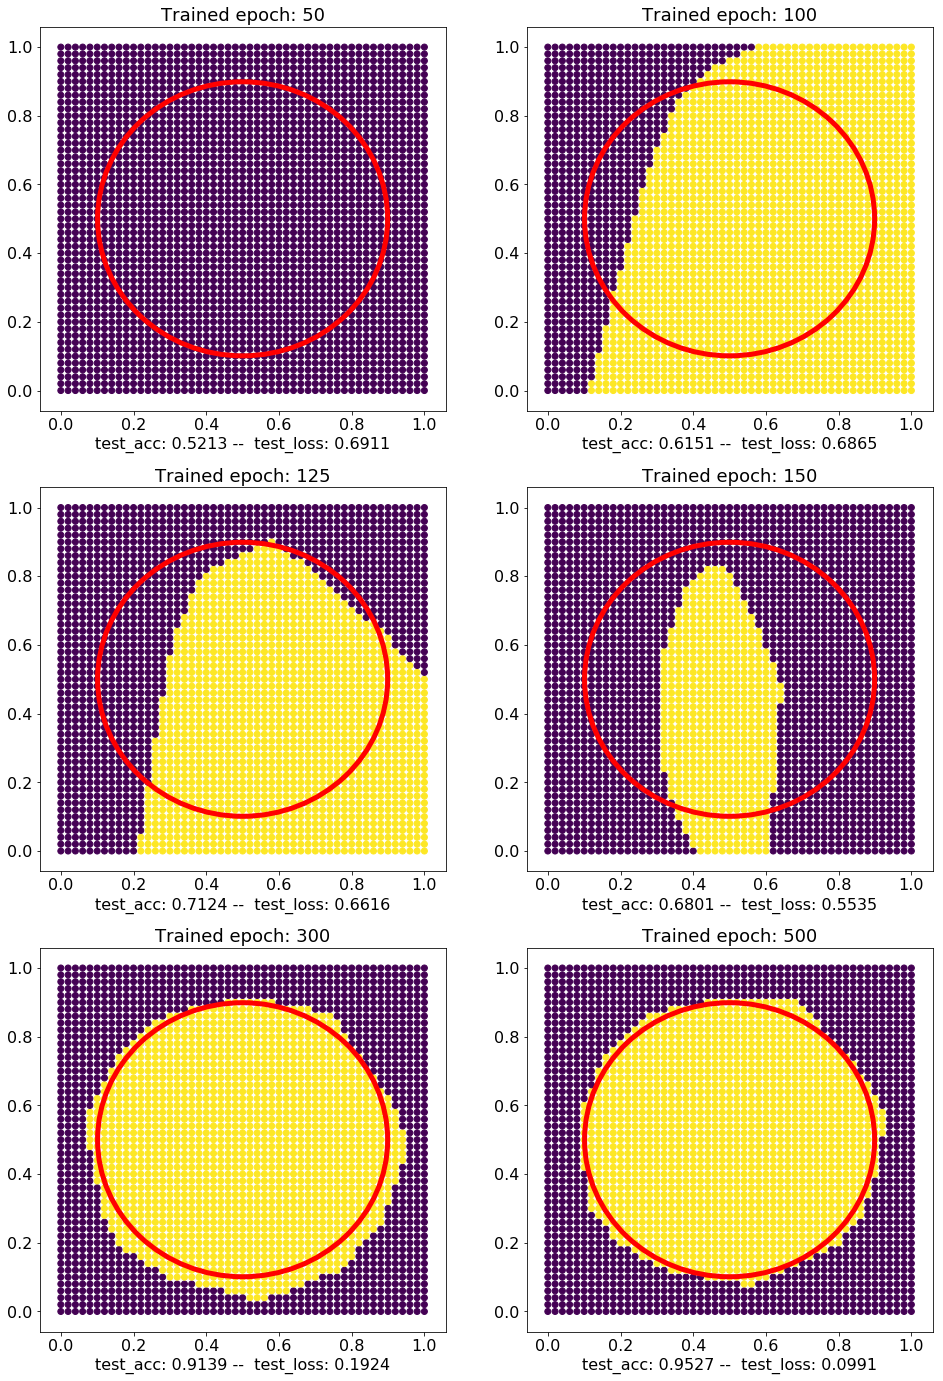

In [62]:
cat_model = get_categorical_model(input_neurons=2, output_neurons=2)

x_train, y_train_label = generate_data(num_of_points=1000)
x_test, y_test_label = generate_grid_data(num_of_points_per_dim=51)

y_train = label2one_hot(y_train_label, val=0)
y_test = label2one_hot(y_test_label, val=0)

opt = SGD(lr=0.1, momentum_coef=0, weight_decay=0.0) 

plot_model_evaluation(opt, 
                      cat_model, 
                      (x_train, y_train), 
                      (x_test, y_test), 
                       epoch_list=[50, 100, 125, 150, 300, 500], 
                      grid_space=(3, 2))

### 4. Testing with MNIST dataset

Since circle classification problem that we have been working on is not very complex task. 
We also wanted to work on MNIST dataset to show the performance/correctness of our implementation.

In [20]:
x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist = load_data(one_hot_labels = True, normalize = True, flatten = True, data_dir = None, cifar = False, full = True, tiny = False, val=0)
_, train_target_mse, _, test_target_mse = load_data(one_hot_labels = True, normalize = True, flatten = True, data_dir = None, cifar = False, full = True, tiny = False, val=-1)

* Using MNIST
** Use 60000 train and 10000 test samples
* Using MNIST
** Use 60000 train and 10000 test samples


In [34]:
cat_model_mnist = get_categorical_model(input_neurons=28*28, output_neurons=10, layers=[512, 256, 128])
cat_model_mnist.print_model()

**************************************************************
Layer Name 		 Input Shape		 Output Shape
**************************************************************
0_Linear		 (784)			 (512)
1_ReLU
2_Linear		 (512)			 (256)
3_ReLU
4_Linear		 (256)			 (128)
5_ReLU
6_Dropout -p:  0.20
7_Linear		 (128)			 (10)
8_Softmax
**************************************************************
Loss Function: 		LossCrossEntropy 
**************************************************************



In [35]:
# create an optimizer 
# by specifying learning rate, momentum coefficent and L2 regularization coefficient
opt = SGD(lr=0.1, momentum_coef=0, weight_decay=0.2) 

# Since this network for generated for classification, we convert y_train_label to one-hot-encoding
# with values 0s and 1s
y_train = label2one_hot(y_train_label, val=0)

# Given model, x_train and y_train optimizer trains model
train_report = opt.train(cat_model_mnist, x_train_mnist, y_train_mnist, 
                        batch_size = 128,   # batch_size
                        num_of_epochs=1000,  # specification of # epochs for training
                        val_split=0.2,  # the ratio of split for validation
                        verbose=1) # set it 1 to report model performance

# Train report is the log of train_loss, train_acc, val_loss and val_acc 
for key, value in train_report.items():
    print('key: {0}, len({0}): {1}'.format(key, len(value)))
    

KeyboardInterrupt: 

In [30]:
test1 = model1.evaluate(test_input, test_target, return_pred=True)

NameError: name 'model1' is not defined

In [ ]:
train_input.size()

fig = plt.figure()
plt.imshow(train_input[9000,:].view(28,28))
plt.show()